In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import catboost
import lightgbm as lgb
import numpy as np
import xgboost
import sklearn
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
#import h2o
import datetime
#from h2o.automl import H2OAutoML
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.common import space

In [4]:
data = pd.read_csv("../data/processed/data.csv", parse_dates=["date_forecast", "date_calc"])

# Modeling Notebook

Each model returns is trained on a subset of the data. The models are then combined into a voting classifier. The voting classifier is then used to predict the test data.

In [5]:
result = {}
test_result = {}

In [200]:
def scale_data(data, cols=None):
    if cols is None:
        ignore_cols = [
            "location",
            "dew_or_rime:idx",
            "is_day:idx",
            "is_in_shadow:idx",
            "pv_measurement",
            "data_type",
        ]

        cols = [col for col in data.columns if col not in ignore_cols]

    X_scaler = MinMaxScaler()
    X_scaler = X_scaler.fit(
        data[data["data_type"].isin(["observed", "estimated"])][cols]
    )
    y_scaler = MinMaxScaler()
    y_scaler = y_scaler.fit(
        data[data["data_type"].isin(["observed", "estimated"])][["pv_measurement"]]
    )

    data_copy = data.copy()

    data_copy[cols] = X_scaler.transform(data_copy[cols])
    data_copy[["pv_measurement"]] = y_scaler.transform(data[["pv_measurement"]])

    return data_copy, X_scaler, y_scaler

## 1. General Model – Catboost (MAE)

### Feature Engineering and Selection

In [201]:
data_general_catboost_mae = data.copy()


# Drop columns that are not needed
drop_cols = [
    # "cloud_base_agl:m",
    # "ceiling_height_agl:m",
    # "snow_density:kgm3",
    "hour",
    "month",
    "date_calc",
    "date_forecast",
    "sun_azimuth:d",
]
data_general_catboost_mae = data_general_catboost_mae.drop(drop_cols, axis=1)

ignore_cols = [
    "location",
    "dew_or_rime:idx",
    "is_day:idx",
    "is_in_shadow:idx",
    "pv_measurement",
    "data_type",
]

cols = [col for col in data_general_catboost_mae.columns if col not in ignore_cols]

data_general_catboost_mae, _, y_scaler = scale_data(data_general_catboost_mae, cols=cols)

# Create training and test data
train = (
    data_general_catboost_mae[
        data_general_catboost_mae["data_type"].isin(["observed", "estimated"])
    ]
    .drop(columns=["data_type"])
    .copy()
)
test = (
    data_general_catboost_mae[data_general_catboost_mae["data_type"] == "test"]
    .drop(columns=["data_type"])
    .copy()
)

### Model Setup

In [202]:
# ---------------------------- CATBOOST ----------------------------


# Create the CatBoost model
model = catboost.CatBoostRegressor(iterations=1000, depth=9, loss_function="MAE")

# Define the number of folds for cross-validation and whether to shuffle the data
n_folds = 5
shuffle = True

# Create the cross-validation object
kFold = KFold(n_splits=n_folds, shuffle=shuffle, random_state=42)

result["general_catboost_mae"] = pd.DataFrame()

temp_test_result = []
temp_test_indices = []

# # Perform k-fold cross-validation
for train_index, validation_index in kFold.split(train):
    print(f"Train Index: {train_index}, Validation Index: {validation_index}")

    fold_train, fold_validation = train.iloc[train_index], train.iloc[validation_index]

    pool_train = catboost.Pool(
        data=fold_train[
            [
                column
                for column in fold_train.columns
                if not column in ["pv_measurement"]
            ]
        ],
        cat_features=["location"],
        label=fold_train[["pv_measurement"]],
    )
    pool_validation = catboost.Pool(
        data=fold_validation[
            [
                column
                for column in fold_validation.columns
                if not column in ["pv_measurement"]
            ]
        ],
        cat_features=["location"],
        label=fold_validation[["pv_measurement"]],
    )

    # Fit the CatBoost model on the training data
    model.fit(
        pool_train,
        verbose=False,
    )

    # Make predictions on the validation data
    predictions = y_scaler.inverse_transform(model.predict(pool_validation).reshape(-1, 1))

    result["general_catboost_mae"] = pd.concat(
        [result["general_catboost_mae"], pd.DataFrame(predictions, index=validation_index)], axis=0
    )

    # Make prediction on the test data
    pool_test = catboost.Pool(
        data=test[
            [
                column
                for column in test.columns
                if not column in ["pv_measurement"]
            ]
        ],
        cat_features=["location"],
        label=test[["pv_measurement"]],
    )

    temp_test_result.append(y_scaler.inverse_transform(model.predict(pool_test).reshape(-1, 1)))
    

test_result["general_catboost_mae"] = pd.DataFrame(np.mean(temp_test_result, axis=0), index=test.index)
result["general_catboost_mae"] = result["general_catboost_mae"].sort_index()

Train Index: [    0     1     2 ... 83042 83043 83044], Validation Index: [   24    35    39 ... 83032 83033 83041]
Train Index: [    0     1     2 ... 83042 83043 83044], Validation Index: [    4     6     7 ... 83020 83034 83038]
Train Index: [    2     4     5 ... 83041 83043 83044], Validation Index: [    0     1     3 ... 83019 83035 83042]
Train Index: [    0     1     2 ... 83040 83041 83042], Validation Index: [    8    14    16 ... 83039 83043 83044]
Train Index: [    0     1     3 ... 83042 83043 83044], Validation Index: [    2     5    15 ... 83031 83036 83040]


### Model Result

In [203]:
mean_absolute_error(result["general_catboost_mae"][0].sort_index(), train["pv_measurement"].sort_index())

308.54977596349534

## 1. General Model – Catboost (RSME)

### Feature Engineering and Selection

In [204]:
data_general_catboost_RMSE = data.copy()

# Drop columns that are not needed
drop_cols = [
    # "cloud_base_agl:m",
    # "ceiling_height_agl:m",
    # "snow_density:kgm3",
    "hour",
    "month",
    "date_calc",
    "date_forecast",
    "sun_azimuth:d",
]
data_general_catboost_RMSE = data_general_catboost_RMSE.drop(drop_cols, axis=1)

ignore_cols = [
    "location",
    "dew_or_rime:idx",
    "is_day:idx",
    "is_in_shadow:idx",
    "pv_measurement",
    "data_type",
]

cols = [col for col in data_general_catboost_RMSE.columns if col not in ignore_cols]

data_general_catboost_RMSE, _, y_scaler = scale_data(data_general_catboost_RMSE, cols=cols)

# Create training and test data
train = data_general_catboost_RMSE[data_general_catboost_RMSE["data_type"].isin(["observed", "estimated"])].drop(columns=["data_type"]).copy()
test = data_general_catboost_RMSE[data_general_catboost_RMSE["data_type"] == "test"].drop(columns=["data_type"]).copy()

### Model Setup

In [205]:
# ---------------------------- CATBOOST ----------------------------


# Create the CatBoost model
model = catboost.CatBoostRegressor(iterations=1000, depth=9, loss_function="RMSE")

# Define the number of folds for cross-validation and whether to shuffle the data
n_folds = 5
shuffle = True

# Create the cross-validation object
kFold = KFold(n_splits=n_folds, shuffle=shuffle, random_state=56)

result["general_catboost_rmse"] = pd.DataFrame()

temp_test_result = []
temp_test_indices = []

# # Perform k-fold cross-validation
for train_index, validation_index in kFold.split(train):
    print(f"Train Index: {train_index}, Validation Index: {validation_index}")

    fold_train, fold_validation = train.iloc[train_index], train.iloc[validation_index]

    pool_train = catboost.Pool(
        data=fold_train[
            [
                column
                for column in fold_train.columns
                if not column in ["pv_measurement"]
            ]
        ],
        cat_features=["location"],
        label=fold_train[["pv_measurement"]],
    )
    pool_validation = catboost.Pool(
        data=fold_validation[
            [
                column
                for column in fold_validation.columns
                if not column in ["pv_measurement"]
            ]
        ],
        cat_features=["location"],
        label=fold_validation[["pv_measurement"]],
    )

    # Fit the CatBoost model on the training data
    model.fit(
        pool_train,
        verbose=False,
    )

    # Make predictions on the validation data
    predictions = y_scaler.inverse_transform(model.predict(pool_validation).reshape(-1, 1))

    result["general_catboost_rmse"] = pd.concat(
        [result["general_catboost_rmse"], pd.DataFrame(predictions, index=validation_index)], axis=0
    )

    # Make prediction on the test data
    pool_test = catboost.Pool(
        data=test[
            [
                column
                for column in test.columns
                if not column in ["pv_measurement"]
            ]
        ],
        cat_features=["location"],
        label=test[["pv_measurement"]],
    )

    temp_test_result.append(y_scaler.inverse_transform(model.predict(pool_test).reshape(-1, 1)))
    

test_result["general_catboost_rmse"] = pd.DataFrame(np.mean(temp_test_result, axis=0), index=test.index)
result["general_catboost_rmse"] = result["general_catboost_rmse"].sort_index()

Train Index: [    0     1     2 ... 83040 83041 83043], Validation Index: [    7     9    13 ... 83033 83042 83044]
Train Index: [    0     2     3 ... 83041 83042 83044], Validation Index: [    1     4     8 ... 83038 83039 83043]
Train Index: [    0     1     2 ... 83042 83043 83044], Validation Index: [    5     6    21 ... 83010 83017 83023]
Train Index: [    1     2     3 ... 83042 83043 83044], Validation Index: [    0    11    15 ... 83031 83034 83040]
Train Index: [    0     1     4 ... 83042 83043 83044], Validation Index: [    2     3    10 ... 83036 83037 83041]


### Model Result

In [206]:
mean_absolute_error(result["general_XGBoost"][0].sort_index(), train["pv_measurement"].sort_index())

320.5476319255183

## 1. General Model – LightGBM

### Feature Engineering and Selection

In [207]:
data_general_lgb = data.copy()

# Drop columns that are not needed
drop_cols = [
    "cloud_base_agl:m",
    "ceiling_height_agl:m",
    "snow_density:kgm3",
    "hour",
    "month",
    "date_calc",
    "sun_azimuth:d",
    "date_forecast"
]
ordinal_encoder = OrdinalEncoder()
data_general_lgb = data_general_lgb.drop(drop_cols, axis=1)
data_general_lgb["location"] = ordinal_encoder.fit_transform(data_general_lgb[["location"]])
data_general_lgb.columns = [column.replace(":", "_") for column in data_general_lgb.columns]

ignore_cols = [
    "location",
    "dew_or_rime:idx",
    "is_day:idx",
    "is_in_shadow:idx",
    "pv_measurement",
    "data_type",
]

cols = [col for col in data_general_lgb.columns if col not in ignore_cols]

data_general_lgb, _, y_scaler = scale_data(data_general_lgb, cols=cols)

# Create training and test data
train = data_general_lgb[data_general_lgb["data_type"].isin(["observed", "estimated"])].drop(columns=["data_type"]).copy()
test = data_general_lgb[data_general_lgb["data_type"] == "test"].drop(columns=["data_type"]).copy()

### Model Setup

In [208]:
# ------------------------- LIGHTGBM ----------------------------

# Create the LightGBM dataset
train_data = lgb.Dataset(train, label=train[["pv_measurement"]])

# Create the LightGBM parameters
params = {
    "objective": "regression",
    "max_depth": 27,
    # "n_estimators": 180,
    "num_leaves": 69,
    # "col_sample_bytree": 10e-1,
    "subsample": 10e-1,
    "reg_alpha": 5e-2,
    "reg_lambda": 0,
    "min_split_gain": 0,
    "min_child_samples": 39,
    "learning_rate": 6e-2,
    "force_row_wise": True,
}
num_boost_round = 1000  # Adjust if needed

# List of categorical feature column names
categorical_features = ["location"]

# Define the number of folds for cross-validation and whether to shuffle the data
n_folds = 5
shuffle = True

# Create the cross-validation object
kFold = KFold(n_splits=n_folds, shuffle=shuffle, random_state=69)

result["general_lightgbm"] = pd.DataFrame()

temp_test_result = []
temp_test_indices = []

# Perform k-fold cross-validation
for train_index, validation_index in kFold.split(train):
    print(f"Train Index: {train_index}, Validation Index: {validation_index}")

    fold_train, fold_validation = train.iloc[train_index], train.iloc[validation_index]

    # Define LightGBM dataset for training and validation
    train_dataset = lgb.Dataset(
        fold_train.drop("pv_measurement", axis=1),
        label=fold_train["pv_measurement"],
        categorical_feature=categorical_features,
    )

    # Train the LightGBM model
    model = lgb.train(
        params,
        train_dataset,
        num_boost_round=num_boost_round,
    )

    # Make predictions on the validation data
    predictions = y_scaler.inverse_transform(model.predict(fold_validation.drop("pv_measurement", axis=1)).reshape(-1, 1))

    result["general_lightgbm"] = pd.concat(
        [result["general_lightgbm"], pd.DataFrame(predictions, index=validation_index)],
        axis=0,
    )

    temp_test_result.append(
        y_scaler.inverse_transform(
            model.predict(test.drop("pv_measurement", axis=1)).reshape(-1, 1)
        )
    )

test_result["general_lightgbm"] = pd.DataFrame(
    np.mean(temp_test_result, axis=0), index=test.index
)
result["general_lightgbm"] = result["general_lightgbm"].sort_index()

Train Index: [    0     1     2 ... 83042 83043 83044], Validation Index: [    6     8    15 ... 83027 83035 83038]
[LightGBM] [Info] Total Bins 8115
[LightGBM] [Info] Number of data points in the train set: 66436, number of used features: 47
[LightGBM] [Info] Start training from score 0.055125


/Users/mathiasraa/anaconda3/envs/forecasting/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Train Index: [    0     1     2 ... 83042 83043 83044], Validation Index: [   12    13    18 ... 83036 83039 83041]
[LightGBM] [Info] Total Bins 8101
[LightGBM] [Info] Number of data points in the train set: 66436, number of used features: 47
[LightGBM] [Info] Start training from score 0.055069


/Users/mathiasraa/anaconda3/envs/forecasting/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Train Index: [    0     3     4 ... 83042 83043 83044], Validation Index: [    1     2    11 ... 83017 83019 83026]
[LightGBM] [Info] Total Bins 8128
[LightGBM] [Info] Number of data points in the train set: 66436, number of used features: 47
[LightGBM] [Info] Start training from score 0.055672


/Users/mathiasraa/anaconda3/envs/forecasting/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Train Index: [    1     2     3 ... 83039 83041 83043], Validation Index: [    0     5     7 ... 83040 83042 83044]
[LightGBM] [Info] Total Bins 8127
[LightGBM] [Info] Number of data points in the train set: 66436, number of used features: 47
[LightGBM] [Info] Start training from score 0.054887


/Users/mathiasraa/anaconda3/envs/forecasting/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Train Index: [    0     1     2 ... 83041 83042 83044], Validation Index: [    3     4     9 ... 83030 83031 83043]
[LightGBM] [Info] Total Bins 8098
[LightGBM] [Info] Number of data points in the train set: 66436, number of used features: 47
[LightGBM] [Info] Start training from score 0.055394


/Users/mathiasraa/anaconda3/envs/forecasting/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


In [209]:
mean_absolute_error(result["general_lightgbm"][0].sort_index(), train["pv_measurement"].sort_index())

318.0922575807243

### Model Result

## 1. General Model – CatBoost (with target transformation)

In [ ]:
data_general_catboost_target_transformation = data.copy()

# Create training and test data
train = data_general_catboost_target_transformation[data_general_catboost_target_transformation["data_type"].isin(["observed", "estimated"])].copy()

# Drop columns that are not needed
drop_cols = [
    # "cloud_base_agl:m",
    # "ceiling_height_agl:m",
    # "snow_density:kgm3",
    "hour",
    "month",
    "date_calc",
    "data_type",
    "sun_azimuth:d"
]

train = train.drop(drop_cols, axis=1)




# Transforming the target value to extract some kind of seasonality







### Model Result

## 2. Summer Model

### Feature Engineering and Selection

In [129]:
# Dropping not important and winter features in train_summer

drop_cols = [
    "ceiling_height_agl:m",
    "cloud_base_agl:m",
    "snow_density:kgm3",
    "elevation:m",
    "precip_5min:mm",
    "precip_type_5min:idx",
    # "pressure_50m:hPa",
    "snow_drift:idx",
    # "dew_or_rime:idx",
    # "dew_point_2m:K",
    "fresh_snow_12h:cm",
    "fresh_snow_1h:cm",
    "fresh_snow_24h:cm",
    "fresh_snow_3h:cm",
    "fresh_snow_6h:cm",
    "snow_depth:cm",
    "snow_melt_10min:mm",
    "snow_water:kgm2",
    # "super_cooled_liquid_water:kgm2",
    "date_calc",
    "date_forecast",
    # "data_type",
    "hour",
    "month",
    "sun_azimuth:d"
]

#dropping
train_summer = train_summer.drop(drop_cols, axis=1)
test_summer = test_summer.drop(drop_cols, axis=1)

# converting is_day:ix and is_in_shadow:ix to integer
train_summer["is_day:idx"] = train_summer["is_day:idx"].astype(int)
train_summer["is_in_shadow:idx"] = train_summer["is_in_shadow:idx"].astype(int)

In [130]:
# Define the number of folds for cross-validation and whether to shuffle the data
n_folds = 5
shuffle = True

# Create the CatBoost model
model = catboost.CatBoostRegressor(iterations=1000, depth=9, loss_function="MAE")

# Create the cross-validation object
kFold = KFold(n_splits=n_folds, shuffle=shuffle, random_state=21)

result["summer_catboost"] = pd.DataFrame()

# # Perform k-fold cross-validation
for train_summer_index, validation_summer_index in kFold.split(train_summer):
    print(f"train_summer Index: {train_summer_index}, Validation Index: {validation_summer_index}")

    fold_train_summer, fold_validation_summer = train_summer.iloc[train_summer_index], train_summer.iloc[validation_summer_index]

    pool_train_summer = catboost.Pool(
        data=fold_train_summer[
            [column for column in fold_train_summer.columns if not column in ["pv_measurement"]]
        ],
        cat_features=["location", "is_day:idx", "is_in_shadow:idx", "data_type"],
        label=fold_train_summer[["pv_measurement"]],
    )
    pool_validation_summer = catboost.Pool(
        data=fold_validation_summer[
            [column for column in fold_validation_summer.columns if not column in ["pv_measurement"]]
        ],
        cat_features=["location", "is_day:idx", "is_in_shadow:idx", "data_type"],
        label=fold_validation_summer[["pv_measurement"]],
    )

    # Fit the CatBoost model on the train_summer data
    model.fit(
        pool_train_summer,
        verbose=False,
    )

    # Make predictions on the validation data
    predictions = model.predict(pool_validation_summer)

    result["summer_catboost"] = pd.concat([result["summer_catboost"], pd.DataFrame(predictions, index=validation_summer_index)], axis=0)

result["summer_catboost"] = result["summer_catboost"].sort_index()
result["summer_catboost"].index = train_summer.index


train_summer Index: [    0     1     3 ... 32615 32616 32617], Validation Index: [    2     7    19 ... 32608 32612 32614]
train_summer Index: [    1     2     3 ... 32615 32616 32617], Validation Index: [    0     4    11 ... 32590 32594 32601]
train_summer Index: [    0     1     2 ... 32612 32614 32617], Validation Index: [    3    16    18 ... 32613 32615 32616]
train_summer Index: [    0     2     3 ... 32615 32616 32617], Validation Index: [    1    10    14 ... 32609 32610 32611]
train_summer Index: [    0     1     2 ... 32614 32615 32616], Validation Index: [    5     6     8 ... 32605 32607 32617]


### Model Result

In [ ]:
mean_absolute_error(result["summer_catboost"][0].sort_index(), train_summer["pv_measurement"].sort_index())

In [131]:
mean_absolute_error(result["summer_catboost"][0].sort_index(), train_summer["pv_measurement"].sort_index())

149.18009450339957

## 3. Summer Model

### Feature Engineering and Selection

In [ ]:
data_cloud = data.copy()
data_cloud = data_cloud[data_cloud["date_forecast"] >= "2020-04-01"]


In [51]:
data_cloud = data.copy()
data_cloud = data_cloud[data_cloud["date_forecast"] >= "2020-04-01"]


In [53]:
train = data_cloud[data_cloud["data_type"].isin(["observed", "estimated"])].copy()

# Drop coloums that are not needed

drop_cols = [
    "snow_density:kgm3",
    "hour",
    "month",
    "date_calc",
    "data_type",
    "sun_azimuth:d",
    "precip_5min:mm",
    "precip_type_5min:idx",
]

train = train.drop(drop_cols, axis=1)

### Model Setup

In [56]:
mean_absolute_error(result["cloud_catboost"][0].sort_index(), train["pv_measurement"].sort_index())

92.1391720403326

## 4. Precipitation Model

In [23]:
data_precip = data.copy()

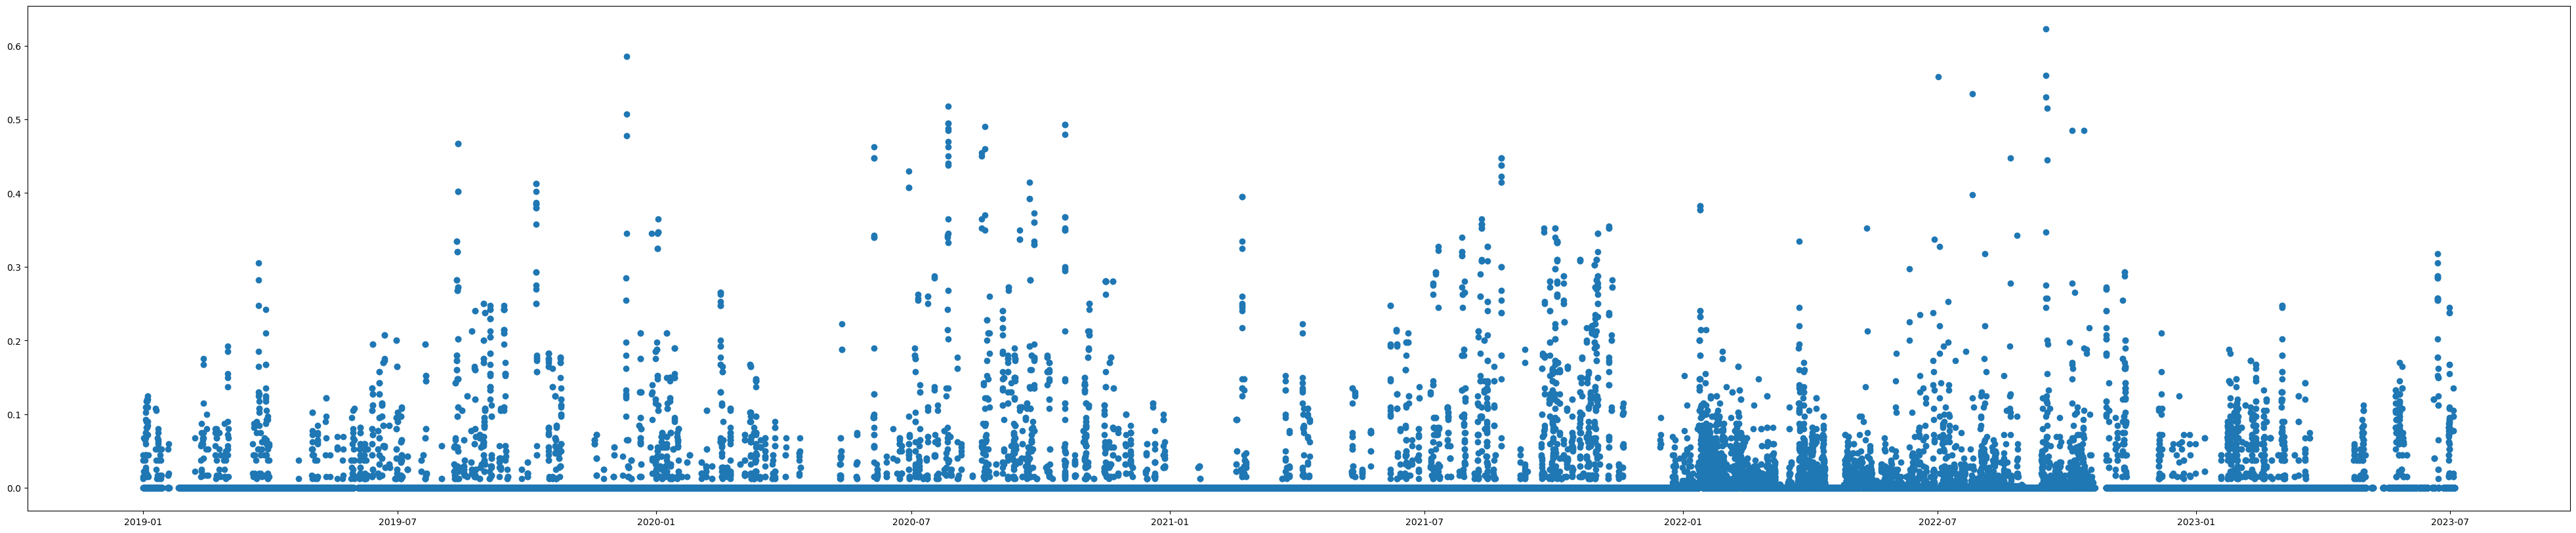

In [24]:
# Observe the outlier data

plt.figure(figsize=(50, 10))
plt.scatter(data_precip["date_forecast"], data_cloud["precip_5min:mm"])

### Model Setup

### Model Result

## Ensemble Model

In [210]:
# Define your target variable (ground truth)
# This should be a numpy array with shape (n_samples, )
target = (
    data[data.data_type.isin(["estimated", "observed"])]
    .pv_measurement.reset_index(drop=True)
    .to_numpy()
)

In [249]:
pred_data = pd.DataFrame()
for key in test_result.keys():
    if not test_result[key].empty:
        pred_data[key] = test_result[key][0]

pred_data

,general_catboost_mae,general_catboost_rmse,general_lightgbm
83045,-0.020705,0.391219,-0.567985
83046,-0.021921,-0.379679,-0.737496
83047,-0.000055,1.000165,-0.514508
83048,-0.022539,-4.722471,-0.703718
83049,-0.023199,-0.262833,-1.010278
...,...,...,...
85200,0.732188,-0.184722,-0.417115
85201,0.055493,1.989518,-1.250790
85202,7.361832,52.841269,28.951532
85203,1.503717,7.315372,3.750231


In [184]:
export = data[data["data_type"] == "test"].copy()[["date_forecast", "location"]]
export["prediction"] = pred_data["general_catboost_mae"]
export = export.sort_values(["location", "date_forecast"]).reset_index(drop=True)
export.to_csv("../data/processed/catboost_new.csv", index=False)

In [221]:
ensamble_data = pd.DataFrame()
for key in result.keys():
    if not result[key].empty:
        ensamble_data[key] = result[key][0]


ensamble_data

,general_catboost_mae,general_catboost_rmse,general_lightgbm
0,0.005483,-0.937258,-1.705526
1,0.000858,-0.404168,-0.490333
2,-0.004087,1.818214,0.201985
3,0.000085,3.179729,5.097704
4,0.004367,-0.371423,3.866576
...,...,...,...
83040,0.006106,0.831255,-0.087229
83041,-0.004866,-1.110484,0.012248
83042,-0.477621,5.275766,-0.289455
83043,-0.005503,-0.784950,-0.814597


In [107]:
ensamble_indices = data[data.data_type.isin(["observed", "estimated"]) & data.date_forecast.dt.month.isin([5, 6, 7, 8])].index

In [242]:
# Define the meta-model as a Random Forest Regressor and perform cross-validation
meta_model = RandomForestRegressor(n_estimators=50, max_depth=9, random_state=42)

y = data[data["data_type"].isin(["estimated", "observed"])]["pv_measurement"].values

meta_model_predictions = cross_val_predict(meta_model, ensamble_data.iloc[ensamble_indices], y[ensamble_indices], cv=5)

# meta_model.fit(ensamble_data.iloc[ensamble_indices], y[ensamble_indices])

# ensamble_predictions = meta_model.predict(pred_data)

# meta_ensemble_model = LinearRegression(fit_intercept=False)
# meta_ensemble_model.fit(ensamble_data, y)

# # Make predictions on the validation set
# ensamble_predictions = meta_ensemble_model.predict(pred_data)

In [276]:
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.tree import DecisionTreeRegressor  

In [264]:
base_estimator = LinearRegression()

bagging_regressor = BaggingRegressor(estimator=base_estimator, random_state=42)

bagging_regressor.fit(ensamble_data.iloc[ensamble_indices], y[ensamble_indices])

ensamble_predictions = bagging_regressor.predict(pred_data)

In [277]:
reg1 = GradientBoostingRegressor(random_state=1)
reg2 = RandomForestRegressor(random_state=1)
reg3 = LinearRegression()
ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
ereg = ereg.fit(ensamble_data.iloc[ensamble_indices], y[ensamble_indices])

In [279]:
ensamble_predictions = ereg.predict(pred_data)

In [265]:
ensamble_predictions

array([-6.22785156, -6.7753775 , -5.84958435, ..., 40.90136964,
        0.1522728 , -5.49523806])

In [280]:
best_submission = pd.read_csv("../data/results/2023-10-23 20:20:14.497423-submission.csv").drop("id", axis=1)
best_submission["location"] = data[data["data_type"] == "test"]["location"].sort_values().values

In [281]:
ensamble_predictions_df = data[data["data_type"] == "test"].copy()[["date_forecast", "location"]]
ensamble_predictions_df["prediction"] = ensamble_predictions
ensamble_predictions_df = ensamble_predictions_df.sort_values(["location", "date_forecast"]).reset_index(drop=True)

In [288]:
ensamble_predictions_df.to_csv("../data/results/ensamble_predictions.csv", index=False)

44.25860341574449

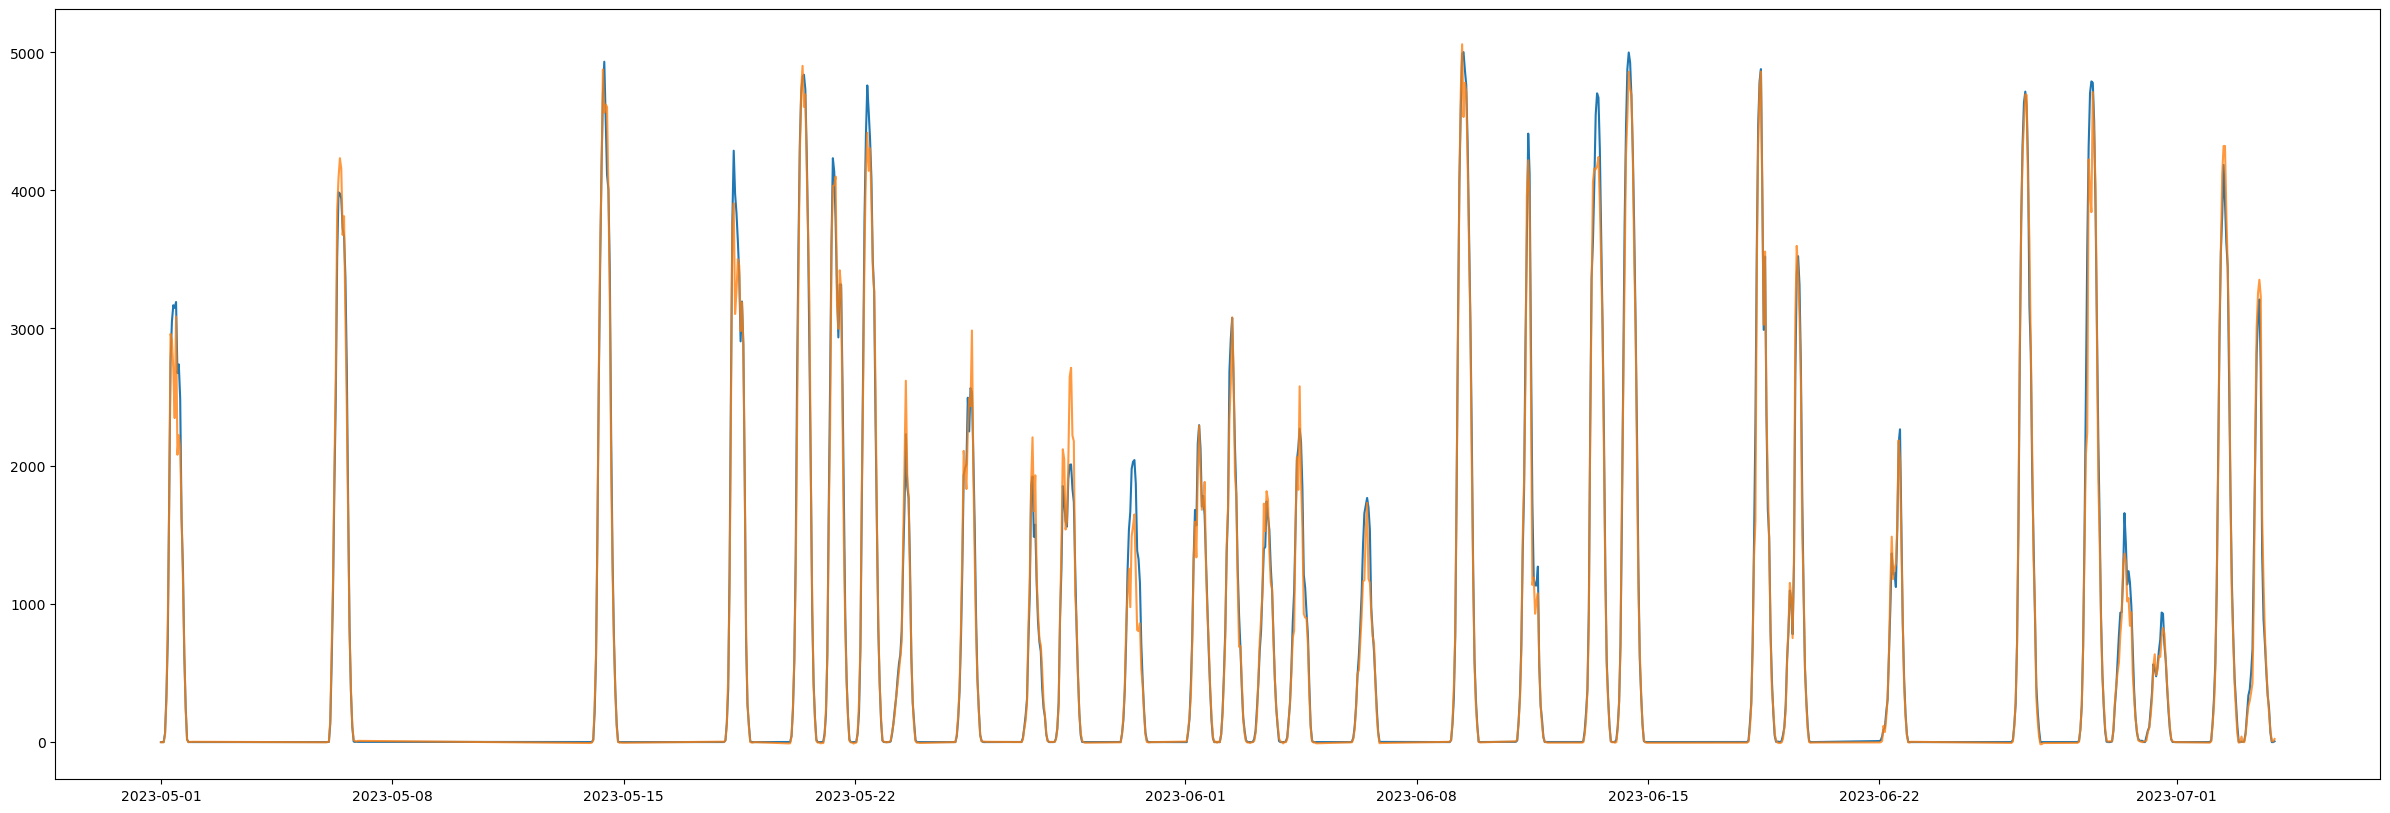

In [287]:
location = "A"

plt.figure(figsize=(30, 10))
plt.plot(ensamble_predictions_df[ensamble_predictions_df.location == location]["date_forecast"], best_submission[best_submission.location == location]["prediction"].values)
plt.plot(ensamble_predictions_df[ensamble_predictions_df.location == location]["date_forecast"], ensamble_predictions_df[ensamble_predictions_df.location == location]["prediction"].values, alpha=0.8)


mean_absolute_error(best_submission["prediction"], ensamble_predictions_df["prediction"])


In [100]:
ensamble_predictions_df.reset_index().rename(columns={"index": "id"})[
    ["id", "prediction"]
].to_csv(f"../data/results/{str(datetime.datetime.now())}-ensamble.csv", index=False)

In [56]:
mean_absolute_error(target, meta_model_predictions)

77.26981202853368

In [24]:
# Let's assume you have predictions from x different models
# Each model's predictions are stored in a list of numpy arrays called 'model_predictions'
# The shape of each model's predictions should be (n_samples, )

# Combine the predictions into a DataFrame
predictions_df = ensamble_data.copy()




# Initialize variables for the meta-ensemble
meta_ensemble_preds = np.zeros(target.shape)
kf = KFold(
    n_splits=5, shuffle=True, random_state=42
)  # You can adjust the number of folds as needed

# Loop through the folds and train the meta-ensemble
for train_index, val_index in kf.split(predictions_df):
    train_preds = predictions_df.iloc[train_index]
    val_preds = predictions_df.iloc[val_index]
    train_target = target[train_index]

    # Fit a linear regression model as the meta-ensemble
    meta_ensemble_model = LinearRegression(fit_intercept=False)
    meta_ensemble_model.fit(train_preds, train_target)

    # Make predictions on the validation set
    meta_ensemble_val_preds = meta_ensemble_model.predict(val_preds)


    print(meta_ensemble_model.coef_)

    # Update the overall meta-ensemble predictions
    meta_ensemble_preds[val_index] = meta_ensemble_val_preds

# Calculate the mean squared error of the meta-ensemble predictions
mse = mean_absolute_error(target, meta_ensemble_preds)

print("Meta-Ensemble MSE:", mse)

[-0.20703618  0.71068208  0.50051913]
[-0.20058726  0.70115848  0.50020406]
[-0.20890839  0.70059245  0.51221049]
[-0.210729    0.72576872  0.48863751]
[-0.2109834   0.7210683   0.49324756]
Meta-Ensemble MSE: 80.41690232350301


## H20 model

### Feature engineering

In [15]:
data_h2o = data.copy()

# one hot encoding the location feature
one_hot = pd.get_dummies(data_h2o["location"]).astype(int)
data_h2o = data_h2o.drop("location", axis=1)
data_h2o = pd.merge(data_h2o, one_hot, left_index=True, right_index=True)

# Drop columns that are not needed
drop_cols = [
    "ceiling_height_agl:m", 
    "cloud_base_agl:m",
    "snow_density:kgm3",
    "elevation:m", 
    "precip_5min:mm",
    "precip_type_5min:idx",
    "pressure_50m:hPa",
    "snow_drift:idx",
    "wind_speed_u_10m:ms",
    "wind_speed_v_10m:ms",
    "wind_speed_w_1000hPa:ms",
    "hour",
    "month",
    "date_calc",
    "date_forecast",
    "sun_azimuth:d"
]

data_h2o = data_h2o.drop(drop_cols, axis=1)

# Scaling train and test features

# deciding what coloumns to exclude from scaling
exclude = ["A", "B", "C", "dew_or_rime:idx", "is_day:idx", "is_in_shadow:idx", "pv_measurement", "data_type"]
# deciding what coloumns to scale
to_scale = [col for col in data_h2o.columns if col not in exclude]
min = data_h2o[data_h2o["data_type"].isin(["estimated", "observed"])][to_scale].min()
max = data_h2o[data_h2o["data_type"].isin(["estimated", "observed"])][to_scale].max()

#scaling
data_h2o[to_scale] = (data_h2o[to_scale] - min) / (max - min)

# scaling pv_measurement with a MinMaxScaler
h2o_scaler_pv = MinMaxScaler()
h2o_scaler_pv = h2o_scaler_pv.fit(data_h2o[data_h2o["data_type"].isin(["estimated", "observed"])][["pv_measurement"]])

data_h2o["pv_measurement"] = h2o_scaler_pv.transform(data_h2o[["pv_measurement"]])

# Create training and test data
train = data_h2o[data_h2o["data_type"].isin(["observed", "estimated"])].copy().drop(columns=["data_type"])
test = data_h2o[data_h2o["data_type"].isin(["test"])].copy().drop(columns=["data_type"])


TypeError: unsupported operand type(s) for -: 'str' and 'str'

### Setup Model


In [ ]:
h2o.init()

train = train.reset_index().drop(columns="index")

h2o_train= h2o.H2OFrame(train)
h2o_test = h2o.H2OFrame(test)

aml = H2OAutoML(max_models=20, seed=1, stopping_metric="MAE", sort_metric="MAE", stopping_tolerance=0.01)

aml.train(x=h2o_train.columns, y="pv_measurement", training_frame=h2o_train)
lb = aml.leaderboard
preds = aml.leader.predict(h2o_test)
lb.head(rows=lb.nrows)

### Results

In [ ]:
prediction_df = preds.as_data_frame()
h2o.cluster().shutdown()
prediction_df_scaled = h2o_scaler_pv.inverse_transform(prediction_df)
prediction_df_scaled_df = pd.DataFrame(prediction_df_scaled)



# removing negative values and replacing with 0

resultframe = pd.DataFrame(columns = ["id", "prediction"])
resultframe["prediction"] = prediction_df_scaled_df
resultframe['prediction'] = np.where(resultframe['prediction'] < 0, 0, resultframe['prediction'])
resultframe["id"] = range(len(resultframe))



In [ ]:
prediction_df.head(50)

In [ ]:
test

In [ ]:
new = resultframe.copy()
new["location"] = test["location"].reset_index(drop=True)

new.sort_values(by=["location", "id"]).head(50)

## AutoGluon

### Feature engineering

In [17]:
data_autogluon = data.copy()

# one hot encoding the location feature
one_hot = pd.get_dummies(data_autogluon["location"]).astype(int)
data_autogluon = data_autogluon.drop("location", axis=1)
data_autogluon = pd.merge(data_autogluon, one_hot, left_index=True, right_index=True)

# Drop columns that are not needed
drop_cols = [
    "ceiling_height_agl:m", 
    "cloud_base_agl:m",
    "snow_density:kgm3",
    "elevation:m", 
    "precip_5min:mm",
    "precip_type_5min:idx",
    "pressure_50m:hPa",
    "snow_drift:idx",
    "wind_speed_u_10m:ms",
    "wind_speed_v_10m:ms",
    "wind_speed_w_1000hPa:ms",
    "hour",
    "month",
    "date_calc",
    "date_forecast",
    "sun_azimuth:d",

    # Duplicate columns
    "prob_rime:p",
    "fresh_snow_1h:cm",
    "dew_or_rime:idx",
    "fresh_snow_3h:cm",
]

data_autogluon = data_autogluon.drop(drop_cols, axis=1)

# Scaling train and test features

# deciding what coloumns to exclude from scaling
exclude = ["A", "B", "C", "dew_or_rime:idx", "is_day:idx", "is_in_shadow:idx", "data_type", "pv_measurement"]
# deciding what coloumns to scale
to_scale = [col for col in data_autogluon.columns if col not in exclude]
min = data_autogluon[data_autogluon["data_type"].isin(["estimated", "observed"])][to_scale].min()
max = data_autogluon[data_autogluon["data_type"].isin(["estimated", "observed"])][to_scale].max()

#scaling
data_autogluon[to_scale] = (data_autogluon[to_scale] - min) / (max - min)

# scaling pv_measurement with a MinMaxScaler
autogluon_scaler_pv = MinMaxScaler()
autogluon_scaler_pv = autogluon_scaler_pv.fit(data_autogluon[data_autogluon["data_type"].isin(["estimated", "observed"])][["pv_measurement"]])

data_autogluon["pv_measurement"] = autogluon_scaler_pv.transform(data_autogluon[["pv_measurement"]])

# Create training and test data
train = data_autogluon[data_autogluon["data_type"].isin(["observed", "estimated"])].copy().drop(columns=["data_type"])
test = data_autogluon[data_autogluon["data_type"].isin(["test"])].copy().drop(columns=["data_type"])


### Setup Model


In [18]:
# Initialize and train AutoGluon model
tabular_predictor = TabularPredictor(label='pv_measurement', eval_metric='mae')

predictor = tabular_predictor.fit(
    train_data=train,
    presets='best_quality',
    num_bag_folds=10,
    num_stack_levels=3
)

No path specified. Models will be saved in: "AutogluonModels\ag-20231025_191454\"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=3, num_bag_folds=10, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20231025_191454\"
AutoGluon Version:  0.8.2
Python Version:     3.10.4
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19044
Disk Space Avail:   214.96 GB / 510.77 GB (42.1%)
Train Data Rows:    83045
Train Data Columns: 38
Label Column: pv_measurement
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (1.0, 0.0, 0.05523, 0.14052)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regre

### Results

In [144]:
# Make predictions on the test dataset
test_data_nolab = test.drop(columns=['pv_measurement'])
y_pred = predictor.predict(test_data_nolab)

# Inverse transform the predictions 
prediction_df_scaled = autogluon_scaler_pv.inverse_transform(y_pred.values.reshape(-1, 1))
autogluon_scaled = pd.DataFrame(prediction_df_scaled)



H2OConnectionError: Connection was closed, and can no longer be used.